In [239]:
"""
Description: SCript to optimize Duca's currency mix.
Author: Jeroen van Dijk & Victor de Graaff
Date: 04-11-2020
Maintainer: Jeroen van Dijk & Victor de Graaff
Email: jeroen.vandijk@d-data.nl & victor.degraaff@d-data.nl
Status: Dev
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import defaultdict
from currency_converter import CurrencyConverter
from datetime import timedelta, date, datetime
from scipy.optimize import minimize

# Set notebook options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 43)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', 15)
pd.set_option('display.precision', 3)

In [240]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def create_original_df(base_currency="EUR"):
    """Create the original dataframe based on ECB data.
   
    Parameters
    ----------
    base_currency : str
        The currency that is used to express other currency exchange rates."""
    c = CurrencyConverter("http://www.ecb.int/stats/eurofxref/eurofxref-hist.zip", 
                          fallback_on_wrong_date=True, 
                          fallback_on_missing_rate=True,
                          decimal=True)

    start_date = date(2000, 1, 1)
    end_date = date.today()

    date_list = []

    for single_date in daterange(start_date, end_date):

        cur_list = []
        cur_list.append(single_date)

        for currency in c.currencies:

            value = c.convert(1, base_currency, currency, date=single_date)
            cur_list.append(float(value))

        date_list.append(cur_list)

    columns_list = ["date"] + list(c.currencies)

    df = pd.DataFrame(date_list, columns=columns_list)
    df = df.sort_values(by="date", ascending=False)
    
    df["date"] = df["date"].map(lambda x: datetime(x.year, x.month, x.day, 0, 0))
    
    return df.sort_values("date").set_index("date")

In [241]:
# Define currencies of interest
p13_currencies = ['USD','EUR','GBP',
                  'CHF','CNY','JPY',
                  'CAD','SEK','NOK',
                  'SGD','AUD','NZD',
                  'ZAR']

# Create dataframe with pre-defined base currency
df = create_original_df("EUR")

# Subset columns of interest
# df = df[currencies]

In [202]:
# Define obsolete currencies (i.e. missings/not existing anymore)
obsolete_currencies = ["ISK", "MXN", "ROL", 
                       "BRL", "CYP", "EEK", 
                       "INR", "ILS", "SIT", 
                       "BGN", "LTL", "MTL", 
                       "TRL", "LVL", "SKK"]
all_currencies = [c for c in df.columns if c not in obsolete_currencies]

In [203]:
# Determine splits for dev- (train and test) and validation set
train_start = date(2005, 4, 1)
test_start = date(2012, 1, 1)
validation_start = date(2015, 1, 1)
validation_end = date(2020, 10, 1)

# Create dev (train and test) and validation set
train = df.query("date >= @train_start and date < @test_start")
test = df.query("date >= @test_start and date < @validation_start")
dev = pd.concat([train, test])
val = df.query("date >= @validation_start and date < @validation_end")

In [206]:
# Function for plotting currency exchange rates in base currency
def plot_base_currency(dataset=dev, base_currency="EUR", plot_in_grey=False):
    plt.figure(figsize=(12, 8))
    plt.title(base_currency)
    
    for currency in p13_currencies:
        if currency == base_currency:
            continue
            
        rates = dataset[base_currency] / dataset[currency]
        normalized_rates = rates / rates.iloc[0]
        
        if plot_in_grey:
            plt.plot(normalized_rates, label=currency, color="grey")
        else:
            plt.plot(normalized_rates, label=currency)
    
    if not plot_in_grey:
        plt.legend()

In [209]:
# Create initial loss function values,
# to find find most/least stable currencies
results = pd.DataFrame()

# Calculate loss function score per currency
for base_currency in all_currencies:
    for currency in all_currencies:
        if currency == base_currency:
            continue
            
        rates = dev[base_currency] / dev[currency]
        normalized_rates = rates / rates.iloc[0]
        
        deviation = np.log(normalized_rates)
        loss_function_score = (deviation**2).mean()

        results = results.append({"currency": currency,
                                  "base_currency": base_currency,
                                  "loss_function_score": loss_function_score},
                                 ignore_index=True)
    
results = results.groupby("currency").median()
results.sort_values("loss_function_score", ascending=True)

,loss_function_score
currency,
CAD,0.015
MYR,0.016
NOK,0.017
HRK,0.020
SEK,0.020
CZK,0.021
EUR,0.021
DKK,0.021
USD,0.021


In [21]:
# Create exchange table for each currency
exchange_table = dict()
for base_currency in all_currencies:
    exchange_table[base_currency] = 1/train[all_currencies].divide(train[base_currency], axis=0)

# Preview USD exchange table
exchange_table["USD"]

,USD,KRW,CZK,NZD,IDR,HRK,PLN,AUD,THB,ZAR,NOK,RUB,GBP,TRY,HKD,MYR,PHP,CHF,CNY,CAD,EUR,RON,DKK,JPY,HUF,SEK,SGD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-04-01,1.0,9.923e-04,0.043,0.711,1.056e-04,0.175,0.317,0.771,0.026,0.162,0.158,0.036,1.887,0.740,0.128,0.263,0.018,0.835,0.121,0.824,1.296,0.360,0.174,0.009,0.005,0.141,0.604
2005-04-02,1.0,9.904e-04,0.043,0.709,1.055e-04,0.174,0.316,0.770,0.025,0.162,0.158,0.036,1.883,0.738,0.128,0.263,0.018,0.833,0.121,0.823,1.293,0.359,0.174,0.009,0.005,0.141,0.603
2005-04-03,1.0,9.886e-04,0.043,0.708,1.055e-04,0.174,0.315,0.769,0.025,0.161,0.157,0.036,1.879,0.736,0.128,0.263,0.018,0.831,0.121,0.822,1.291,0.358,0.173,0.009,0.005,0.141,0.602
2005-04-04,1.0,9.867e-04,0.043,0.707,1.054e-04,0.174,0.313,0.768,0.025,0.161,0.157,0.036,1.875,0.733,0.128,0.263,0.018,0.829,0.121,0.821,1.288,0.358,0.173,0.009,0.005,0.140,0.600
2005-04-05,1.0,9.828e-04,0.043,0.704,1.053e-04,0.173,0.310,0.764,0.025,0.160,0.157,0.036,1.873,0.731,0.128,0.263,0.018,0.824,0.121,0.817,1.281,0.356,0.172,0.009,0.005,0.140,0.601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-27,1.0,8.652e-04,0.051,0.774,1.086e-04,0.174,0.297,1.016,0.032,0.123,0.168,0.032,1.568,0.526,0.129,0.315,0.023,1.070,0.158,0.981,1.307,0.305,0.176,0.013,0.004,0.146,0.771
2011-12-28,1.0,8.651e-04,0.051,0.778,1.087e-04,0.174,0.297,1.020,0.032,0.123,0.168,0.032,1.567,0.526,0.129,0.316,0.023,1.072,0.158,0.985,1.307,0.305,0.176,0.013,0.004,0.146,0.772
2011-12-29,1.0,8.658e-04,0.050,0.767,1.087e-04,0.171,0.290,1.007,0.031,0.123,0.166,0.031,1.542,0.523,0.129,0.315,0.023,1.058,0.158,0.977,1.289,0.300,0.173,0.013,0.004,0.144,0.767


In [208]:
# Exchange rates on reference date (first observation)
reference_date_exhange_rate = train[all_currencies].iloc[0]

In [22]:
# Loss function 1
def calculate_loss_function_around_one(weights):
    weights = weights / weights.sum()
    amounts = weights * reference_date_exhange_rate

    # TODO: penalize large coefficients?
    loss_function_score = 0

    for base_currency in currencies:
        amounts_through_time = amounts * exchange_table[base_currency]
        normalized_amounts_through_time = amounts_through_time.sum(axis=1) / reference_date_exhange_rate[base_currency]
        
        # TODO: other possibilities for loss functions:
        # - Mean Absolute Error MAE
        # - Root Mean Squared Error RMSE
        # - Time-series related loss functions (research)
        
        deviation = np.log(normalized_amounts_through_time)
        loss_function_score += (deviation**2).mean()
    
    return loss_function_score

In [25]:
# Loss function 2
def calculate_loss_function_vs_t_minus_one(weights):
    weights = weights / weights.sum()
    amounts = weights * reference_date_exhange_rate.loc[p13_currencies]

    loss_function_score = 0

    for base_currency in p13_currencies:
        amounts_through_time = (amounts * exchange_table[base_currency]).sum(axis=1)
        loss_function_score += (np.abs(amounts_through_time - amounts_through_time.shift(1))/amounts_through_time).mean()

    return loss_function_score

         Current function value: 0.035171
         Iterations: 1
         Function evaluations: 42
         Gradient evaluations: 3
0.03517108670406959


EUR    0.083
SEK    0.082
NOK    0.081
GBP    0.080
SGD    0.080
CNY    0.079
USD    0.078
CHF    0.077
JPY    0.075
AUD    0.074
CAD    0.073
NZD    0.071
ZAR    0.068
dtype: float64

In [ ]:
# Give starting point
starting_point = np.ones(13)/13

# Find best solution (with lowest loss function value)
result = minimize(calculate_loss_function_vs_t_minus_one, starting_point, options={"disp": True, "maxiter": 100})

# Save best solution as duca_mix
duca_mix = pd.Series(result.x/result.x.sum(), index=reference_date_exhange_rate.loc[p13_currencies].index)

# Print final loss function value and corresponding duca mix
print(calculate_loss_function_vs_t_minus_one(duca_mix))
duca_mix.sort_values(ascending=False)

In [215]:
# Loss function 3
def calculate_loss_function_vs_t_minus_one_with_balancing(weights):
    print("evaluate")
    
    # Ensure we never deviate from 100% total, and only use positive numbers
    weights = np.abs(weights) / np.abs(weights).sum()  
    
    # Calculate the weights after rebalancing for each month
    amounts_by_month = {month: weights / this_day_by_month["EUR"][month].iloc[0][p13_currencies] for month in months}
    
    # Calculate the loss function per base currency, per month
    return sum([sum([(amounts_by_month[month] * diff_by_month[base_currency][month]).sum(axis=1).sum() for month in months]) 
                for base_currency in p13_currencies])

In [223]:
# Define boundaries for currency weights
bounds = [(0,1) for _ in range(len(p13_currencies))]
# Define starting point
starting_point = np.ones(13)/13

# Calculate result
result = minimize(calculate_loss_function_vs_t_minus_one_with_balancing, starting_point, bounds=bounds, options={"disp": True, 
                                                                                                                 "maxiter": 2,
                                                                                                                 })
duca_mix = pd.Series(result.x/result.x.sum(), index=reference_date_exhange_rate.loc[p13_currencies].index)
# print(calculate_loss_function_vs_t_minus_one_with_balancing(duca_mix))
duca_mix.sort_values(ascending=False)

evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate
evaluate


NZD    0.108
AUD    0.108
SGD    0.108
CAD    0.108
CHF    0.108
GBP    0.108
EUR    0.108
USD    0.108
NOK    0.052
CNY    0.043
SEK    0.041
ZAR    0.000
JPY    0.000
dtype: float64

In [216]:
this_day_by_month = {}
previous_day_by_month = {}
diff_by_month = defaultdict(dict)

for base_currency, table in exchange_table.items():
    if base_currency not in p13_currencies:
        continue
        
    exchange_table[base_currency]["month"] = exchange_table[base_currency].index.map(lambda x: int(x.strftime("%Y%m")))

    this_day = exchange_table[base_currency]
    previous_day = pd.DataFrame(exchange_table[base_currency].shift(1), 
                                index=exchange_table[base_currency].index)
    previous_day["month"] = previous_day.index.map(lambda x: int(x.strftime("%Y%m")))
    
    this_day_by_month[base_currency] = {month: values[p13_currencies] for month, values in this_day.groupby("month")}
    previous_day_by_month[base_currency] = {month: values[p13_currencies] for month, values in previous_day.groupby("month")}
    
    for month in this_day_by_month[base_currency].keys():
        diff_by_month[base_currency][month] = np.abs((this_day_by_month[base_currency][month] - previous_day_by_month[base_currency][month]) / 
                                                      previous_day_by_month[base_currency][month])
    
months = list(exchange_table["EUR"]["month"].unique())

In [182]:
# Loss function 4
def calculate_loss_function_vs_t_minus_one_for_period(weights, max_date):
    weights = weights / weights.sum()
    amounts = weights * reference_date_exhange_rate.loc[p13_currencies]

    loss_function_score= 0

    for base_currency in p13_currencies:
        amounts_through_time = (amounts * exchange_table[base_currency].loc[:max_date]).sum(axis=1)
        loss_function_score += (np.abs(amounts_through_time - amounts_through_time.shift(1))/amounts_through_time).mean()

    return loss_function_score

In [222]:
def get_libra_mix(reference_date_exhange_rate):
    result = pd.Series(np.zeros(len(reference_date_exhange_rate)), index=reference_date_exhange_rate.index)
    
    result["USD"] = .5
    result["EUR"] = .18
    result["JPY"] = .14
    result["GBP"] = .11
    result["SGD"] = .07
    
    return result


def get_sdr_mix(reference_date_exhange_rate):
    result = pd.Series(np.zeros(len(reference_date_exhange_rate)), index=reference_date_exhange_rate.index)
    
    result["USD"] = .4173
    result["EUR"] = .3093
    result["CNY"] = .1092
    result["JPY"] = .0833
    result["GBP"] = .0809
    
    return result

assert get_libra_mix(reference_date_exhange_rate).sum() == 1
assert get_sdr_mix(reference_date_exhange_rate).sum() == 1

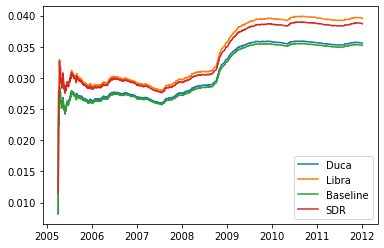

In [224]:
if True:
    # Useful, but takes very long to run
    duca_mix_lf_values, libra_mix_lf_values, sdr_mix_lf_values, baseline_lf_values = [], [], [], []

    for date in train.index:
        duca_mix_lf_values += [calculate_loss_function_vs_t_minus_one_for_period(duca_mix, date)]
        libra_mix_lf_values += [calculate_loss_function_vs_t_minus_one_for_period(get_libra_mix(reference_date_exhange_rate.loc[p13_currencies]), date)]
        sdr_mix_lf_values += [calculate_loss_function_vs_t_minus_one_for_period(get_sdr_mix(reference_date_exhange_rate.loc[p13_currencies]), date)]
        baseline_lf_values += [calculate_loss_function_vs_t_minus_one_for_period(np.ones(13)/13, date)]

    plt.plot(train.index, duca_mix_lf_values, label="Duca")
    plt.plot(train.index, libra_mix_lf_values, label="Libra")
    plt.plot(train.index, baseline_lf_values, label="Baseline")
    plt.plot(train.index, sdr_mix_lf_values, label="SDR")
    
    plt.legend()

In [650]:
# TODO: vary with starting points: 
# - what if we don't include a certain currency
# - what if we start from USD all the way?

# Start with even playing field
# starting_point = np.ones(len(currencies))/len(currencies)
# USD    0.087
# EUR    0.099
# GBP    0.080
# CHF    0.060
# CNY    0.056
# JPY    0.071
# CAD    0.077
# SEK    0.073
# NOK    0.066
# SGD    0.071
# AUD    0.093
# NZD    0.074
# ZAR    0.094
# 0.17275234458598143

# Start with USD only
# starting_point = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
# USD    0.108
# EUR    0.106
# GBP    0.067
# CHF    0.063
# CNY    0.039
# JPY    0.067
# CAD    0.082
# SEK    0.081
# NOK    0.056
# SGD    0.072
# AUD    0.095
# NZD    0.075
# ZAR    0.088
# 0.1727539055816972

# Start with all but ZAR
# starting_point = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
# USD    0.088
# EUR    0.087
# GBP    0.077
# CHF    0.066
# CNY    0.058
# JPY    0.072
# CAD    0.081
# SEK    0.076
# NOK    0.080
# SGD    0.064
# AUD    0.084
# NZD    0.075
# ZAR    0.093
# 0.17275471022697475

# Start randomly
# np.random.seed(42)
# starting_point = np.array([np.random.rand() for _ in range(13)])
# USD    0.075
# EUR    0.100
# GBP    0.077
# CHF    0.053
# CNY    0.052
# JPY    0.074
# CAD    0.075
# SEK    0.072
# NOK    0.075
# SGD    0.091
# AUD    0.079
# NZD    0.079
# ZAR    0.099
# 0.17275405004452105

result = minimize(calculate_loss_function, starting_point, options={"disp": True, "maxiter": 100})
duca_mix = pd.Series(result.x/result.x.sum(), index=reference_date_exhange_rate.index)
print(calculate_loss_function(duca_mix))
duca_mix

Optimization terminated successfully.
         Current function value: 0.172754
         Iterations: 80
         Function evaluations: 1148
         Gradient evaluations: 82
0.17275405004452105


USD    0.075
EUR    0.100
GBP    0.077
CHF    0.053
CNY    0.052
JPY    0.074
CAD    0.075
SEK    0.072
NOK    0.075
SGD    0.091
AUD    0.079
NZD    0.079
ZAR    0.099
dtype: float64

### Volatility score per currency

In [242]:
# TODO: use the same system to score the loss function
# See: https://en.wikipedia.org/wiki/Volatility_(finance) 
#      header: Alternative measures of volatility
# 
# Idea: we want to reduce the upwards and downwards motions: to make it as stable as possible

volatilities = pd.DataFrame()

for base_currency in p13_currencies:
    df = create_original_df(base_currency)
    train = df.query("date >= @train_start and date < @test_start")

    for currency in p13_currencies:
        if currency == base_currency:
            continue
        # DONE: this is all based on the exchange rate with the EUR only, what if we sum all base currencies?
        volatilities = volatilities.append({"base_currency": base_currency,
                                            "currency": currency, 
                                            "volatility": np.abs((train[currency] - train[currency].shift(1))/train[currency]).mean()},
                                           ignore_index=True)
    
volatilities.sort_values("volatility")
# TODO: what about this approach? https://www.mdpi.com/1911-8074/12/2/54

,base_currency,currency,volatility
48,CNY,USD,4.616e-04
3,USD,CNY,4.620e-04
56,CNY,SGD,1.810e-03
112,SGD,CNY,1.811e-03
108,SGD,USD,1.883e-03
...,...,...,...
144,ZAR,USD,5.961e-03
70,JPY,NZD,6.108e-03
137,NZD,JPY,6.124e-03
71,JPY,ZAR,7.101e-03


In [243]:
# summarize volatilities per currency (summed up per baseline currency)
volatilities.groupby("currency").sum().sort_values("volatility")

,volatility
currency,
SGD,0.039
EUR,0.039
GBP,0.044
CNY,0.045
USD,0.045
SEK,0.046
NOK,0.046
CHF,0.046
CAD,0.049


In [578]:
# Run with all 27 sensible valuta:
# KRW    0.047
# HKD    0.052
# USD    0.040
# PLN    0.030
# THB    0.047
# EUR    0.035
# ZAR    0.041
# RON    0.022
# SEK    0.043
# AUD    0.038
# JPY    0.028
# DKK    0.037
# RUB    0.036
# CAD    0.042
# HRK    0.066
# CNY    0.018
# CHF    0.030
# GBP    0.033
# NOK    0.027
# MYR    0.045
# TRY    0.041
# PHP    0.019
# HUF    0.043
# NZD    0.038
# IDR    0.042
# CZK    0.040
# SGD    0.021

# duca_mix = result.x

# (calculate_loss_function(duca_mix), 
#  calculate_loss_function(np.ones(len(duca_mix))/len(duca_mix)), 
#  calculate_loss_function(get_libra_mix(reference_date_exhange_rate)), 
#  calculate_loss_function(get_sdr_mix(reference_date_exhange_rate)))

#  0.33854436038561553,
#  0.3400650723585818,
#  0.3842956486350562,
#  0.37333119031548356

(0.33854436038561553,
 0.3400650723585818,
 0.3842956486350562,
 0.37333119031548356)

In [636]:
# Run with 13 initial valuta:
# USD    0.087
# EUR    0.099
# GBP    0.080
# CHF    0.060
# CNY    0.056
# JPY    0.071
# CAD    0.077
# SEK    0.073
# NOK    0.066
# SGD    0.071
# AUD    0.093
# NZD    0.074
# ZAR    0.094

# (calculate_loss_function(duca_mix), 
#  calculate_loss_function(np.ones(len(duca_mix))/len(duca_mix)), 
#  calculate_loss_function(get_libra_mix(reference_date_exhange_rate)), 
#  calculate_loss_function(get_sdr_mix(reference_date_exhange_rate)))

#  0.17275234458598143,
#  0.17356119062704128,
#  0.19408065329315338,
#  0.19287288245710466

(0.17275234458598143,
 0.17356119062704128,
 0.19408065329315338,
 0.19287288245710466)

In [255]:
reference_date_exhange_rate[p13_currencies]

USD      1.296
EUR      1.000
GBP      0.687
CHF      1.553
CNY     10.726
JPY    139.070
CAD      1.574
SEK      9.169
NOK      8.195
SGD      2.145
AUD      1.680
NZD      1.824
ZAR      8.012
Name: 2005-04-01 00:00:00, dtype: float64

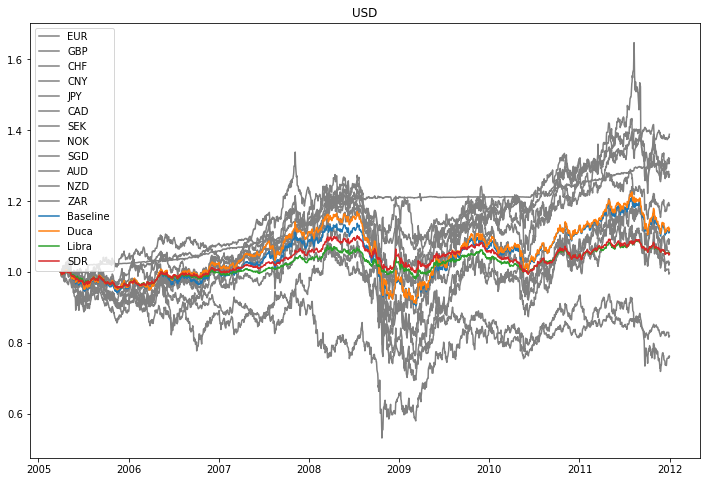

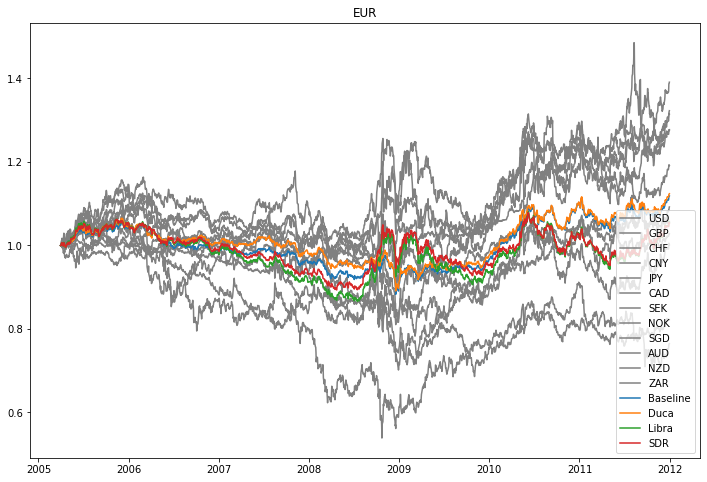

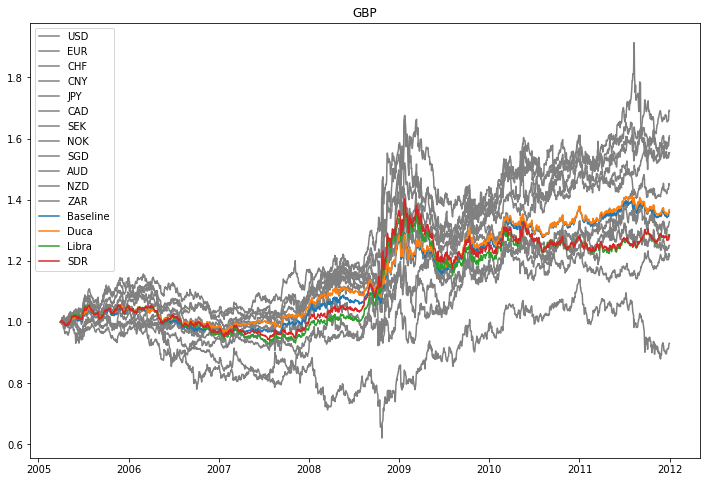

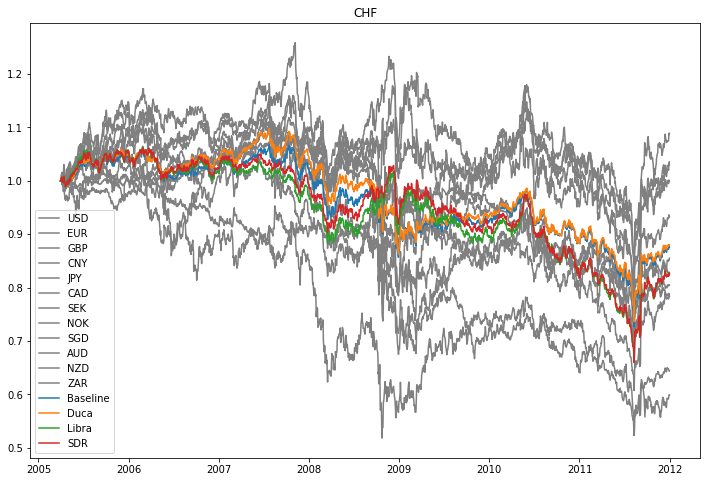

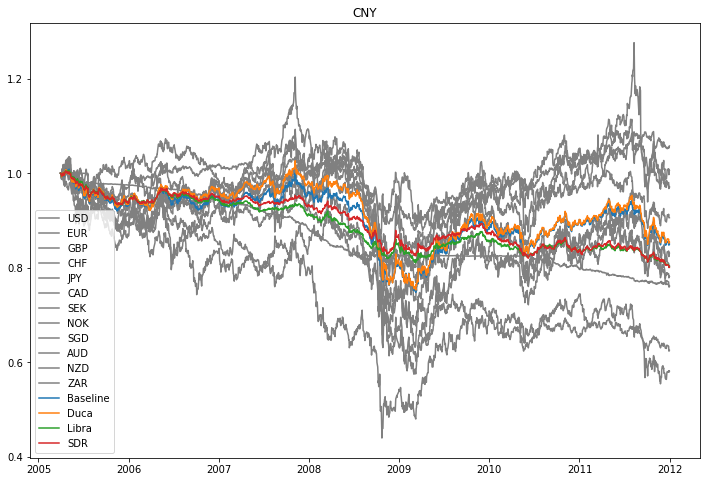

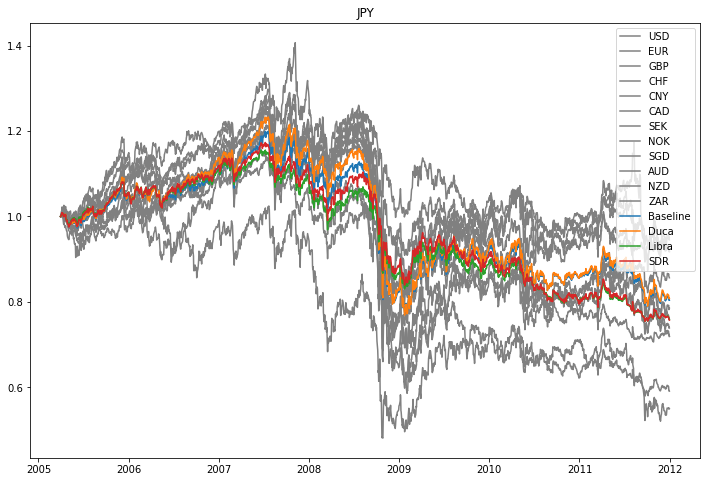

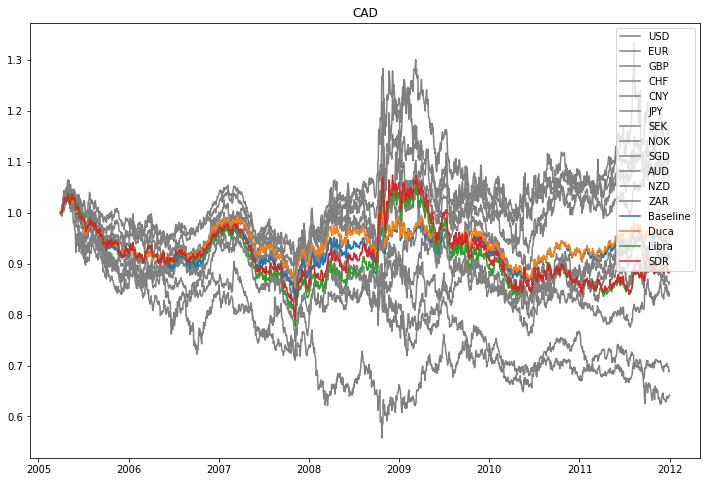

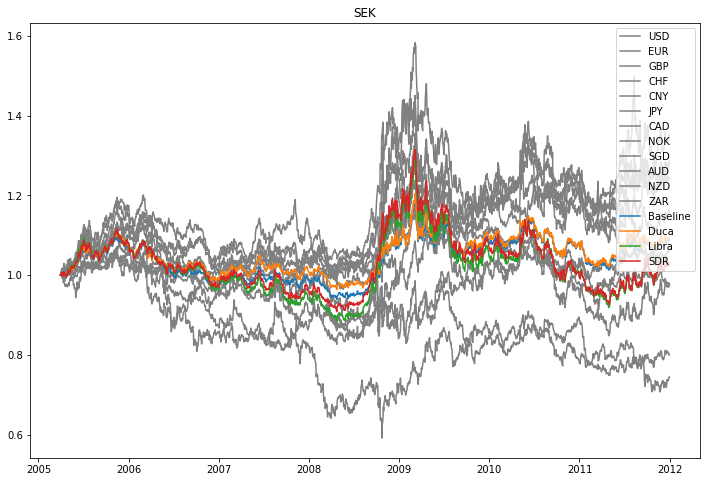

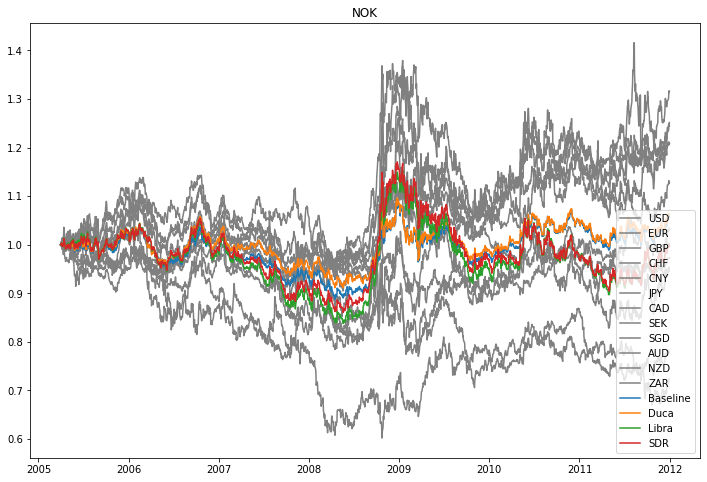

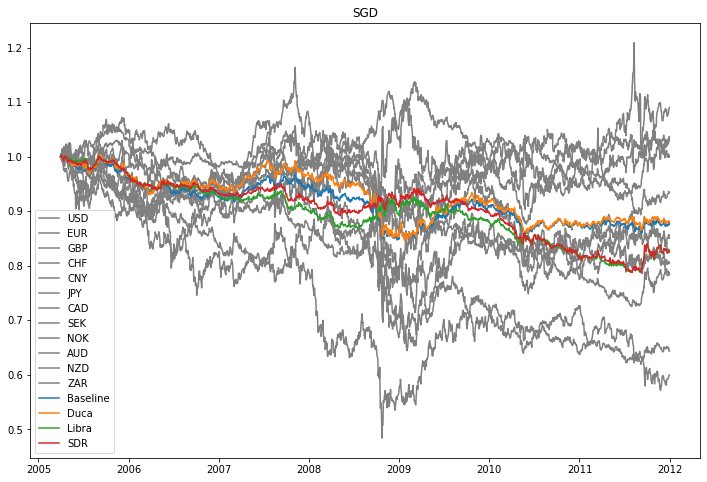

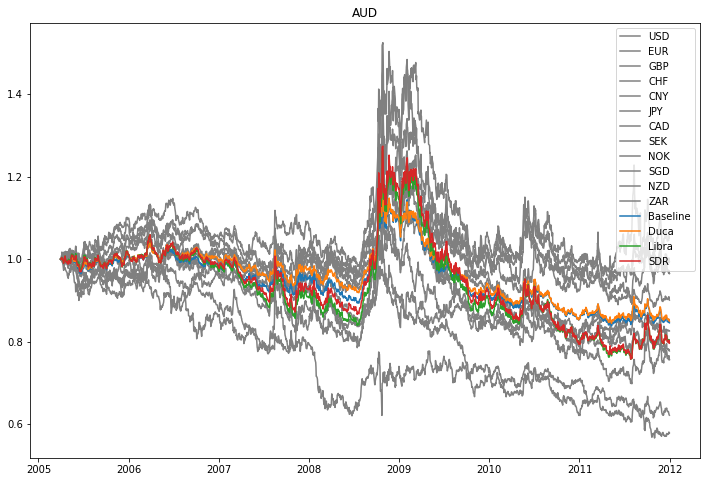

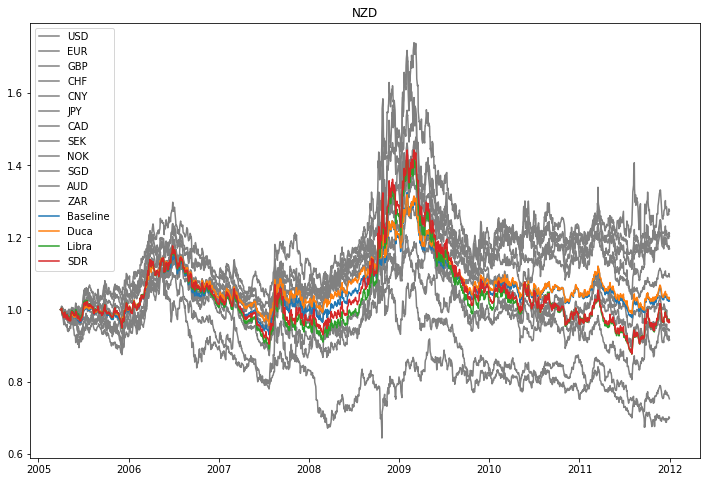

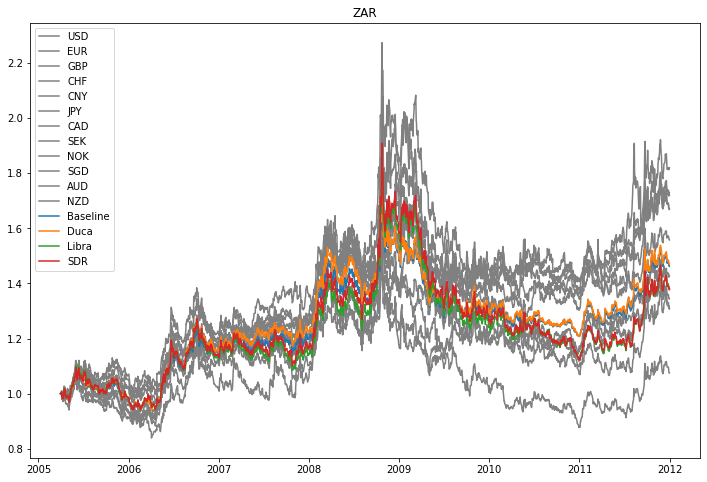

In [259]:
duca_mix = result.x

def plot_valuta_mix(weights, base_currency, currencies, label):
    amounts = weights/weights.sum() * reference_date_exhange_rate[p13_currencies]
    amounts_through_time = amounts * exchange_table[base_currency]

    normalized_amounts_through_time = amounts_through_time.sum(axis=1) / reference_date_exhange_rate[base_currency]
    plt.plot(normalized_amounts_through_time, label=label)

for base_currency in p13_currencies:
    plot_base_currency(dataset=train, base_currency=base_currency, plot_in_grey=True)

    plot_valuta_mix(np.ones(len(duca_mix))/len(duca_mix), base_currency, p13_currencies, "Baseline")
    plot_valuta_mix(duca_mix, base_currency, p13_currencies, "Duca")
    plot_valuta_mix(get_libra_mix(reference_date_exhange_rate), base_currency, p13_currencies, "Libra")
    plot_valuta_mix(get_sdr_mix(reference_date_exhange_rate), base_currency, p13_currencies, "SDR")

    plt.legend()